# Modelo Knn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV # Importamos GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc
)
# Importamos las librerías para GPU
import cudf
from cuml.neighbors import KNeighborsClassifier as cuKNN

In [2]:
# --- 1. CARGA Y DIVISIÓN DE DATOS ---
df = pd.read_csv('diabetic_data.csv')
# Reemplazar '?' por NaN para un manejo más fácil
df.replace('?', np.nan, inplace=True)

# Crear variable objetivo binaria
df['target'] = df['readmitted'].isin(['<30']).astype(int) # Simplificado a <30 vs. el resto

# Eliminar columnas que no usaremos
df = df.drop(columns=['encounter_id', 'patient_nbr', 'readmitted', 'weight', 'payer_code', 'medical_specialty'])

# Separar las características (X) de la variable objetivo (y).
X = df.drop('target', axis=1)
y = df['target']

# Rellenar NaNs en columnas categóricas con la moda (el valor más frecuente)
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].fillna(X[col].mode()[0])

# Identificar qué columnas son numéricas y cuáles son categóricas.
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12, stratify=y)

In [3]:

# --- 2. PREPROCESAMIENTO ---
print("Preprocesando datos...")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Mantiene las columnas no especificadas
)

# Aplicar preprocesamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- 3. CONVERSIÓN A FORMATOS DE GPU ---
print("Convirtiendo datos para GPU...")

# Convertir a float32 para mejor rendimiento en GPU
X_test_gpu = cudf.DataFrame(X_test_processed.astype(np.float32))

Preprocesando datos...
Convirtiendo datos para GPU...


In [4]:

# --- 4. BÚSQUEDA DE HIPERPARÁMETROS CON GRIDSEARCHCV ---
print("\nIniciando la búsqueda de hiperparámetros con GridSearchCV...")

# Definir la cuadrícula de parámetros a probar
param_grid = {
    'n_neighbors': [5, 7, 9, 11, 15]
}

# Instanciar el modelo base de cuML
knn_base = cuKNN()


grid_search = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 folds
    scoring='accuracy',
    verbose=2, # Muestra el progreso
    n_jobs=-1
)

# Ejecutar la búsqueda en los datos de entrenamiento de la GPU
grid_search.fit(X_train_processed, y_train)


Iniciando la búsqueda de hiperparámetros con GridSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 7, 9, 11, 15]}, scoring='accuracy',
             verbose=2)

In [5]:

# --- 5. RESULTADOS DE GRIDSEARCHCV ---
print("\n--- Resultados de GridSearchCV ---")
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor puntuación de Accuracy (validación cruzada): {grid_search.best_score_:.4f}")

# El mejor modelo ya está entrenado y se puede acceder a él a través de .best_estimator_
best_knn_gpu = grid_search.best_estimator_


--- Resultados de GridSearchCV ---
Mejores parámetros encontrados: {'n_neighbors': 15}
Mejor puntuación de Accuracy (validación cruzada): 0.8878


Gracias al grid search podemos ver que con un k=15 se alcanza un precision de 88%


     EVALUACIÓN DETALLADA DEL MEJOR MODELO

--- Matriz de Confusión ---


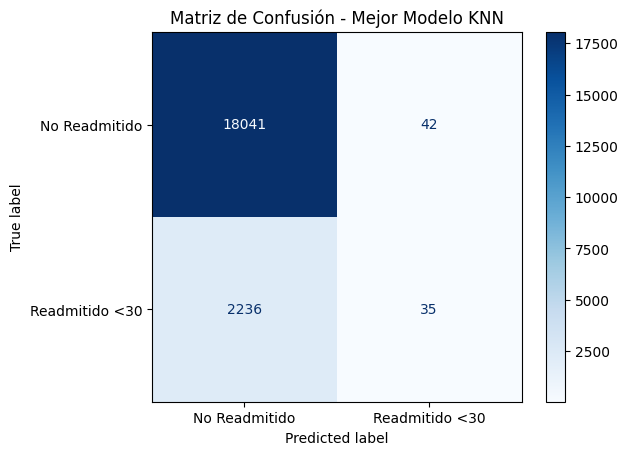


--- Reporte de Clasificación ---
                precision    recall  f1-score   support

 No Readmitido       0.89      1.00      0.94     18083
Readmitido <30       0.45      0.02      0.03      2271

      accuracy                           0.89     20354
     macro avg       0.67      0.51      0.49     20354
  weighted avg       0.84      0.89      0.84     20354


--- Curva ROC ---


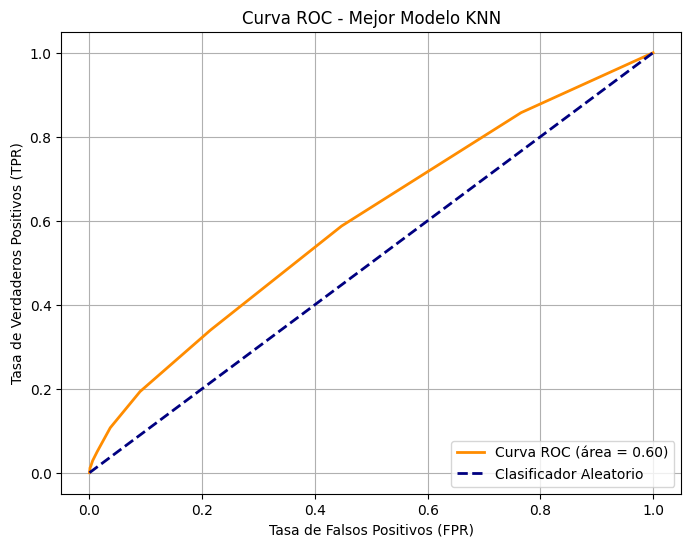

In [9]:
# --- 6. EVALUACIÓN DETALLADA DEL MEJOR MODELO ---
print("\n" + "="*50)
print("     EVALUACIÓN DETALLADA DEL MEJOR MODELO")
print("="*50)

# Predecir clases para métricas que las requieren (matriz, reporte)
y_pred_gpu = best_knn_gpu.predict(X_test_gpu)
y_pred_cpu = y_pred_gpu.to_numpy() # Convertir a NumPy para métricas de scikit-learn

# Matriz de confusión
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred_cpu)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Readmitido', 'Readmitido <30'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Mejor Modelo KNN')
plt.show()

# Reporte de clasificación
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred_cpu, target_names=['No Readmitido', 'Readmitido <30']))

# Curva ROC y AUC
print("\n--- Curva ROC ---")
# La curva ROC es ideal para clasificación binaria
if len(np.unique(y_test)) == 2:
    # Predecir probabilidades para la curva ROC
    y_proba_gpu = best_knn_gpu.predict_proba(X_test_gpu)
    y_proba_cpu = y_proba_gpu.to_numpy()[:, 1]  # Probabilidades de la clase positiva (1)

    # Calcular métricas para la curva
    fpr, tpr, _ = roc_curve(y_test, y_proba_cpu)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC - Mejor Modelo KNN')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("La curva ROC solo se muestra para problemas de clasificación binaria.")

Grcias a las metricas podemos ver con que el modelo predice muy bien la clase mayoritaria, los pacientes no readmitidos, y le cuesta un poco identificar aquellos que fueron readmitidos en los primeros 30 dias, eso puede deberse al desbalance de las clases.

In [11]:
# --- 7. GUARDAR EL MODELO Y PREPROCESADOR ---
# Guardamos el preprocesador
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)
print("Preprocesador guardado exitosamente en 'preprocessor.pkl'")

# Guardamos el mejor modelo entrenado
with open('best_knn_model.pkl', 'wb') as file:
    pickle.dump(best_knn_gpu, file)
print("Mejor modelo KNN guardado exitosamente en 'best_knn_model.pkl'")

Preprocesador guardado exitosamente en 'preprocessor.pkl'
Mejor modelo KNN guardado exitosamente en 'best_knn_model.pkl'
